# A1: Data Curation

#### The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2019. 


## Step 1: Data Acquisition

#### In order to measure Wikipedia traffic from 2008-2019, we collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

The Legacy Pagecounts API - provides access to desktop and mobile traffic data from December 2007 through July 2016.
https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end

The Pageviews API - provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.
https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

The API's accept the following parameters
1. project - in our case it is en.wikipedia.org
2. access-site - type of access, desktop/mobile
3. granularity - monthly, daily, yearly
4. start - date in yyyymmddhh format
5. end - date in yyyymmddhh format
6. agent - used to differentiate between users and callers (only available for Pageviews API)

In [267]:
# Import libraries
import json
import requests

In [268]:
# API ENDPOINTS
WIKIMEDIA_ENDPOINT = "https://wikimedia.org/api/rest_v1" 
PAGECOUNT_ENDPOINT =  WIKIMEDIA_ENDPOINT + \
                        "/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}"
PAGEVIEW_ENDPOINT = WIKIMEDIA_ENDPOINT + \
                        "/metrics/pageviews/aggregate/{project}/{access-site}/{agent}/{granularity}/{start}/{end}"


# API params
pagecounts_params = {
                    'project' : 'en.wikipedia.org',
                    'access-site' : '',
                    'granularity' : 'monthly',
                    'start' : '2008010100',
                    'end' : '2019100100'
                    }
pageviews_params = {
                    'project' : 'en.wikipedia.org',
                    'access-site' : '',
                    'agent': 'user',
                    'granularity' : 'monthly',
                    'start' : '2008010100',
                    'end' : '2019100100'
                    }

# Function tocall an API
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters))
    response = call.json()
    
    return response

# Function to write json to file
def write_json_to_file(filename,data):
    with open(filename,'w') as f:
        json.dump(data,f)

### 1.1 Acquire Pagecount data

Fetching pagecount data and writing them data/raw directory

In [269]:
# Making API request to fetch pagecounts data from wikimedia 

pagecounts_params["access-site"]="desktop-site"
pagecounts_desktop = api_call(PAGECOUNT_ENDPOINT,pagecounts_params)

pagecounts_params["access-site"]="mobile-site"
pagecounts_mobile =  api_call(PAGECOUNT_ENDPOINT,pagecounts_params)

# Write pagecounts-desktop to file
write_json_to_file('data/raw/pagecounts_desktop-site_200801-201909.json',pagecounts_desktop)
    
# Write pagecounts-mobile to file    
write_json_to_file('data/raw/pagecounts_mobile-site_200801-201909.json',pagecounts_mobile)

print("Sample record in items object of the response")
print(pagecounts_desktop["items"][0])

Sample record in items object of the response
{'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2008010100', 'count': 4930902570}


### 1.2 Acquire Pageview data

Fetching pageview data and writing it to data/raw directory

In [270]:
# Making API requests to fetch pageview data from wikimedia

pageviews_params["access-site"]="desktop"
pageviews_desktop = api_call(PAGEVIEW_ENDPOINT,pageviews_params)

pageviews_params["access-site"]="mobile-web"
pageviews_mobile_site = api_call(PAGEVIEW_ENDPOINT,pageviews_params)

pageviews_params["access-site"]="mobile-app"
pageviews_mobile_app = api_call(PAGEVIEW_ENDPOINT,pageviews_params)

# Write pageviews desktop to file
write_json_to_file('data/raw/pageviews_desktop-site_200801-201909.json',pageviews_desktop)

# Write pageviews mobile site to file 
write_json_to_file('data/raw/pageviews_mobile-site_200801-201909.json',pageviews_mobile_site)

# Write pageviews mobile site to file    
write_json_to_file('data/raw/pageviews_mobile-app_200801-201909.json',pageviews_mobile_app)
        
    
print("Sample record in items object of the response")
print(pageviews_desktop["items"][0])    

Sample record in items object of the response
{'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015070100', 'views': 4376666686}


## Step 2: Data Processing


In [271]:
import pandas as pd
import json

### 2.1 Process Pagecounts data

#### For pagecounts data, we perform the following steps as part of data processing

1. Read the json file and convert it to a pandas dataframe
2. Drop unwanted columns from the dataframe, store only timestamp and the counts/views
3. Left outer join mobile and desktop views on timestamp
4. Compute total number of views and store it a new column in the dataframe
5. Rename columns


In [272]:
# 1. Read from json files and covert to pandas dataframe
with open('data/raw/pagecounts_desktop-site_200801-201909.json') as f:
    pagecount_desktop = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')
    
with open('data/raw/pagecounts_mobile-site_200801-201909.json') as f:
    pagecount_mobile = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')

# 2. Drop unwanted columnes    
pagecount_desktop = pagecount_desktop.drop(['access-site','granularity','project'], axis=1)
pagecount_mobile = pagecount_mobile.drop(['access-site','granularity','project'], axis=1)

# 3. Join data frames
pagecounts = pd.merge(pagecount_desktop,pagecount_mobile, on='timestamp', how='outer')

# 4. Add mobile and desktop views for totall views
pagecounts["pagecount_all_views"] = pagecounts["count_x"] + pagecounts["count_y"]

# 5. Rename columns
pagecounts = pagecounts.rename(index=str, 
                               columns={"count_x": "pagecount_desktop_views", 
                                        "count_y": "pagecount_mobile_views"})

### 2.2 Process Pageview Data

#### For pageview data, we perform the following steps as part of data processing

1. Read the json file and convert it to a pandas dataframe
2. Add mobile site and mobile app to get mobile views
3. Drop unwanted columns from the dataframe, store only timestamp and the counts/views
4. Left outer join mobile and desktop views on timestamp
5. Compute total number of views and store it a new column in the dataframe
6. Rename columns

In [273]:
# 1. Read from json files and convert to pandas dataframe
with open('data/raw/pageviews_desktop-site_200801-201909.json') as f:
    pageview_desktop = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')
    
with open('data/raw/pageviews_mobile-site_200801-201909.json') as f:
    pageview_mobile_site = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')

with open('data/raw/pageviews_mobile-app_200801-201909.json') as f:
    pageview_mobile_app = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')

# 2. Add mobile site and mobile app to get mobile views
pageview_mobile_site['views'] = pageview_mobile_site['views'] + pageview_mobile_app['views']  

# 3. Drop unwanted columns
pageview_desktop = pageview_desktop.drop(['access','granularity','project','agent'], axis=1)
pageview_mobile_site = pageview_mobile_site.drop(['access','granularity','project','agent'], axis=1)

# 4. Left outer join mobile and desktop
pageviews = pd.merge(pageview_desktop,pageview_mobile_site, on='timestamp', how='outer')

# 5. Compute total number of views 
pageviews["pageview_all_views"] = pageviews["views_x"] + pageviews['views_y']

# 6. Rename columns
pageviews = pageviews.rename(index=str, 
                             columns={"views_x": "pageview_desktop_views", 
                                      "views_y": "pageview_mobile_views"})


### 2.3 Combine pagecounts and pageviews dataframe

1. Join pageviews and pagecounts on timestamp
2. Fill all NA's with 0's
3. Reformat timestamp to store year and month in separate columns
4. Reorder columns
5. Store file in csv

In [274]:
# 1. Join pageviews and pagecounts on timestamp
total_views = pd.merge(pagecounts,pageviews,on='timestamp',how='outer')

# 2. Fill all NA's with 0's
total_views = total_views.fillna(0)

# 3. Reformat timestamp to store year and month in separate columns and drop timestamp column
total_views['year'] = total_views['timestamp'].str[0:4]
total_views['month'] = total_views['timestamp'].str[4:6]
total_views = total_views.drop(["timestamp"],axis=1)

# 4. Reorder columns
total_views = total_views[['year','month',
                           'pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
                           'pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

# 5. Write to csv 
total_views.to_csv('data/clean/en-wikipedia_traffic_200801-201809.csv',index=False)

print("First 5 rows of the csv file")
total_views.head(5)

First 5 rows of the csv file


,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,0.0,4.930903e+09,0.0,0.0,0.0,0.0
1,2008,02,0.0,4.818394e+09,0.0,0.0,0.0,0.0
2,2008,03,0.0,4.955406e+09,0.0,0.0,0.0,0.0
3,2008,04,0.0,5.159162e+09,0.0,0.0,0.0,0.0
4,2008,05,0.0,5.584691e+09,0.0,0.0,0.0,0.0


## Step 3: Analysis

#### To do the analysis, we perform the following steps

1. Read csv file and convert to dataframe
2. Generate pandas series from start data to end date
3. Plot using matplotlib

In [275]:
import matplotlib.pyplot as plt
import pandas as pd

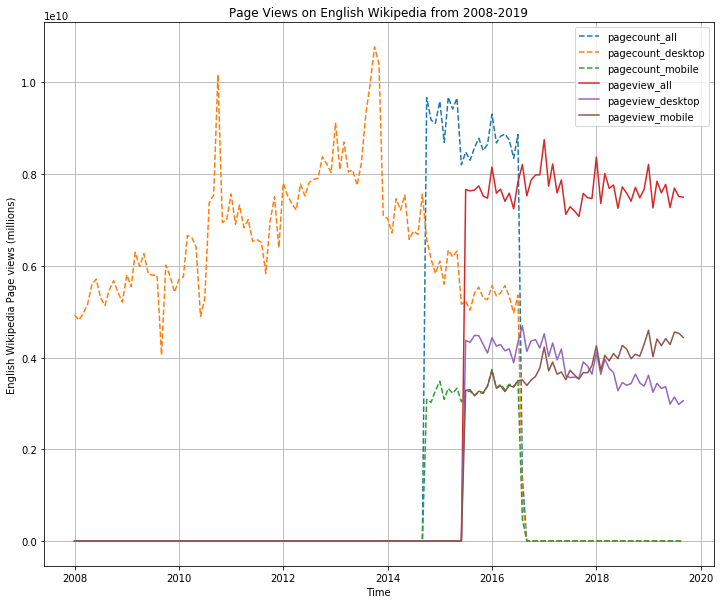

In [287]:
# 1. Read csv file
total_views = pd.read_csv("data/clean/en-wikipedia_traffic_200801-201809.csv")

# 2. Generate pandas series from start to end
xAxis = pd.date_range('2008-01', '2019-09', freq='MS')

# 3. Plot

# Create a new figure with appropriate dimensions.
fig = plt.figure(figsize=(12, 10))

# Plot pagecounts using linestyle --
plt.plot(xAxis, total_views["pagecount_all_views"],linestyle = "--", label = "pagecount_all")
plt.plot(xAxis, total_views["pagecount_desktop_views"],linestyle = "--", label = "pagecount_desktop")
plt.plot(xAxis, total_views["pagecount_mobile_views"],linestyle = "--", label = "pagecount_mobile")

# Plot pageviews 
plt.plot(xAxis, total_views["pageview_all_views"],label = "pageview_all")
plt.plot(xAxis, total_views["pageview_desktop_views"], label = "pageview_desktop")
plt.plot(xAxis, total_views["pageview_mobile_views"],  label = "pageview_mobile")

# Labels and title
plt.legend(loc=1)
plt.xlabel("Time")
plt.ylabel("English Wikipedia Page views (millions)")
plt.title("Page Views on English Wikipedia from 2008-2019")

# Show grid
plt.grid(True)

# Display plot
plt.savefig('english-wikipedia-views-2008-2019.jpg')
plt.show()



## 4. Observations

#### 1. As seen from the above graph, pagecounts data is available only from January 2008 through July 2016.
#### 2. Pageview data wasn't available till July 2015
#### 3. Pagecounts data didn't differentiate between web crawlers and organic users
#### 4. Pageview data accounts for web crawlers, filtering them out we find pageview_all is smaller than pagecount_all which is to be expected 
#### 5. Mobile views appear to be slowly increasing while the desktop views are declining.